# MNIST Classification using TenSEAL

This notebook provides functions to learn on the MNIST dataset (unencrypted)
and perform inference on encrypted data.

For the inference step the activation function can be chosen among various options.

However, there is a bug to be fixed in the inference step.

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from pathlib import Path
import pickle
import gzip
import numpy as np
import tenseal as ts

In [121]:
# Definitions
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x,0)

def approx_coefficients(fct, deg, int_min, int_max):
    x = np.linspace(int_min, int_max, 1000)
    coeffs = np.polyfit(x.tolist(), fct(x).tolist(), deg)
    return coeffs

In [122]:
# Parameters
activation = "square"
poly_degree = 4
poly_coeffs = []
approx_interval = ([-10,10])
a_fct = None

def fct_approx(x):
    a = poly_coeffs[0]
    for c in poly_coeffs[1:]:
        a = a*x + c
    return a

if activation == "relu":
    learning_act = F.relu
    poly_coeffs = approx_coefficients(fct=relu,deg=poly_degree,int_min=approx_interval[0],int_max=approx_interval[1])
    
elif activation == "sigmoid":
    learning_act = torch.sigmoid
    poly_coeffs = approx_coefficients(fct=sigmoid,deg=poly_degree,int_min=approx_interval[0],int_max=approx_interval[1])
    
elif activation == "square":
    learning_act = torch.square
    
elif activation == "relu_approx":
    learning_act = fct_approx
    poly_coeffs = approx_coefficients(fct=relu,deg=poly_degree,int_min=approx_interval[0],int_max=approx_interval[1])
    
elif activation == "sigmoid_approx":
    learning_act = fct_approx
    poly_coeffs = approx_coefficients(fct=sigmoid,deg=poly_degree,int_min=approx_interval[0],int_max=approx_interval[1])

In [123]:
# Model Definitions
class Linear_Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784,30),
            nn.Linear(30,10)
        )
        
    def forward(self, x):
        return self.model(x)
    
class Linear_Mnist_wAct(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Linear(784,30)
        self.L2 = nn.Linear(30,10)
        
    def forward(self, x):
        x = learning_act(self.L1(x))
        x = learning_act(self.L2(x))
        return x
    
class Conv_Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = nn.Linear(256,30)
        self.fc2 = nn.Linear(30,10)
        # images are 28x28 ("size")
        # (size + 2*padding - kernel_size) / stride + 1 = 256
        
    def forward(self, x):
        x = learning_act(self.conv(x))
        # flattening while keeping the batch axis
        x = x.view(-1, 256)
        x = learning_act(self.fc1(x))
        x = self.fc2(x)
        return x

In [124]:
# Definitions (II)
def get_data(train_ds, valid_ds, test_ds, bs):
    return ( DataLoader(train_ds, batch_size=bs, shuffle=True),
             DataLoader(valid_ds, batch_size=bs * 2), 
             DataLoader(test_ds, batch_size=1), )

def loss_batch(model, loss_func, xb, yb, opt=None):
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    acc = accuracy(y_pred, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), acc, len(xb)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [164]:
# Model & Data
loss_func = F.cross_entropy
lr = 0.01
epochs = 10
bs = 64

#-- Model ---------------------------------------------------------------------#
model = Linear_Mnist()
#------------------------------------------------------------------------------#
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay = 1e-4)

# Data
if type(model) == Conv_Mnist:
    # Data for convolution
    train_data = datasets.MNIST('data', train=True, download=False, transform=transforms.ToTensor())
    
    train_ds, valid_ds = torch.utils.data.random_split(train_data, [50000, 10000])
    
    test_ds = datasets.MNIST('data', train=False, download=False, transform=transforms.ToTensor())
    
else:
    DATA_PATH = Path('./local_data/')
    PATH = DATA_PATH
    FILENAME = "mnist.pkl.gz"

    with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
            ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")
    x_train, y_train, x_valid, y_valid, x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))
    train_ds = TensorDataset(x_train, y_train)
    valid_ds = TensorDataset(x_valid, y_valid)
    test_ds = TensorDataset(x_test, y_test)
    
train_dl, valid_dl, test_dl = get_data(train_ds, valid_ds, test_ds, bs)

In [165]:
# LEARNING
print("  |   TRAINING    |     TEST")
print("ep|  loss   acc   |  loss   acc")
print("---------------------------------")
for epoch in range(epochs):
    model.train()
    losses, accs, counts = zip(*[loss_batch(model, loss_func, xb, yb, opt) for xb,yb in train_dl])
    train_loss = np.sum(np.multiply(losses,counts)) / np.sum(counts)
    train_acc = np.sum(np.multiply(accs,counts)) / np.sum(counts)
    
    model.eval()
    with torch.no_grad():
        losses, accs, counts = zip(*[loss_batch(model, loss_func, xb, yb) for xb,yb in valid_dl])
        
    eval_loss = np.sum(np.multiply(losses,counts)) / np.sum(counts)
    eval_acc = np.sum(np.multiply(accs,counts)) / np.sum(counts)
    
    print(f"{epoch+1:2d}| {train_loss:.4f} {train_acc:.4f} | {eval_loss:.4f} {eval_acc:.4f}")

  |   TRAINING    |     TEST
ep|  loss   acc   |  loss   acc
---------------------------------
 1| 0.4937 0.8658 | 0.2973 0.9141
 2| 0.3161 0.9103 | 0.2806 0.9206
 3| 0.2989 0.9154 | 0.2853 0.9228
 4| 0.2915 0.9186 | 0.2868 0.9192
 5| 0.2854 0.9201 | 0.2758 0.9232
 6| 0.2811 0.9206 | 0.2694 0.9251
 7| 0.2788 0.9212 | 0.2633 0.9280
 8| 0.2765 0.9231 | 0.2800 0.9193
 9| 0.2743 0.9231 | 0.2593 0.9280
10| 0.2723 0.9235 | 0.2653 0.9273


In [172]:
# save model parameters
file = None
params = dict()

if type(model) == Conv_Mnist:
    params["conv_w"] = model.conv.weight.data.view(model.conv.out_channels, model.conv.kernel_size[0],
            model.conv.kernel_size[1])
    params["conv_b"] = model.conv.bias.data.tolist()
    params["fc1_w"] = model.fc1.weight.T.data
    params["fc1_b"] = model.fc1.bias.data
    params["fc2_w"] = model.fc2.weight.T.data
    params["fc2_b"] = model.fc2.bias.data

    file = open(f"data/MNIST_Conv_{activation}.dat", "wb")

elif type(model) == Linear_Mnist:
    params["fc1_w"] = model.model[0].weight.T.data
    params["fc1_b"] = model.model[0].bias.data
    params["fc2_w"] = model.model[1].weight.T.data
    params["fc2_b"] = model.model[1].bias.data
    file = open(f"data/MNIST_Lin_{activation}.dat", "wb")

elif type(model) == Linear_Mnist_wAct:
    params["fc1_w"] = model.L1.weight.T.data
    params["fc1_b"] = model.L1.bias.data
    params["fc2_w"] = model.L2.weight.T.data
    params["fc2_b"] = model.L2.bias.data
    file = open(f"data/MNIST_LinAct_{activation}.dat", "wb")
    
pickle.dump(params, file)

file.close()

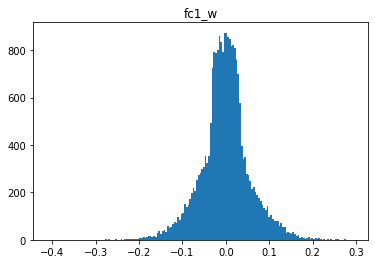

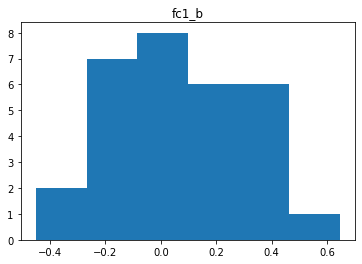

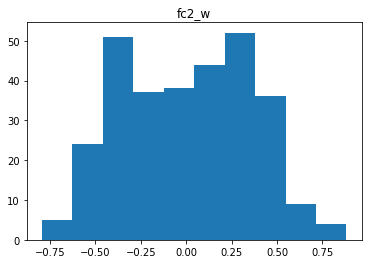

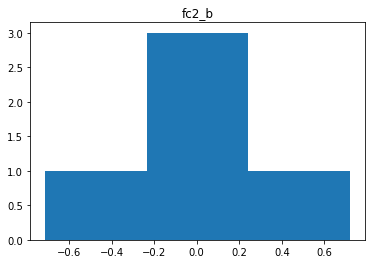

In [173]:
# plot parameter histograms
import numpy as np
import matplotlib.pyplot as plt

def plot(data, title):
    d = np.array(data).flatten()
    _ = plt.hist(d, 'auto')
    plt.title(title)
    plt.show()
    
for k,v in params.items():
    plot(v,k)

In [174]:
# HE handling model
class HE_MNIST_Conv():
    def __init__(self,params):
        self.conv_w = params["conv_w"]
        self.conv_b = params["conv_b"]
        self.fc1_w = params["fc1_w"]
        self.fc1_b = params["fc1_b"]
        self.fc2_w = params["fc2_w"]
        self.fc2_b = params["fc2_b"]
        
        self.ctx = None
        
    def setupHE(self, context):
        self.ctx = ts.context_from(context)
        
    def forward_approx(self, x, windows_nb):
        x = ts.ckks_vector_from(self.ctx, x)
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv_w, self.conv_b):
            y = x.conv2d_im2col(kernel, windows_nb)
            y += bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        x = ts.CKKSVector.pack_vectors(enc_channels)
        x = fct_approx(x)
        # fc1 layer
        x = x.mm(self.fc1_w) + self.fc1_b        
        x = fct_approx(x)
        # fc2 layer
        x = x.mm(self.fc2_w) + self.fc2_b
        return x.serialize()
    
    def forward_square(self, x, windows_nb):
        x = ts.ckks_vector_from(self.ctx, x)
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv_w, self.conv_b):
            y = x.conv2d_im2col(kernel, windows_nb)
            y += bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        x = ts.CKKSVector.pack_vectors(enc_channels)
        x.square_()
        # fc1 layer
        x = x.mm(self.fc1_w) + self.fc1_b        
        x.square_()
        # fc2 layer
        x = x.mm(self.fc2_w) + self.fc2_b
        return x.serialize()
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def forward(self, *args, **kwargs):
        return self.forward_square(*args, **kwargs)
    
class HE_MNIST_Linear():
    def __init__(self,params,activation):
        self.fc1_w = params["fc1_w"]
        self.fc1_b = params["fc1_b"]
        self.fc2_w = params["fc2_w"]
        self.fc2_b = params["fc2_b"]
        self.activation = activation
        
        self.ctx = None
        
    def setupHE(self, context):
        self.ctx = ts.context_from(context)
        
    def forward_square(self, x, _):
        x = ts.ckks_vector_from(self.ctx, x)

        # fc1 layer
        x = x.mm(self.fc1_w) + self.fc1_b
        if self.activation:
            x.square_()
        # fc2 layer
        x = x.mm(self.fc2_w) + self.fc2_b
        return x.serialize()
    
    def forward_approx(self, x, _):
        x = ts.ckks_vector_from(self.ctx, x)

        # fc1 layer
        x = x.mm(self.fc1_w) + self.fc1_b
        if self.activation:
            x = fct_approx(x)
        # fc2 layer
        x = x.mm(self.fc2_w) + self.fc2_b
        return x.serialize()
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def forward(self, *args, **kwargs):
        return self.forward_square(*args, **kwargs)

In [175]:
# SEAL Context
poly_modulus_degree = 0
coeff_mod_bit_sizes = []
mid_bit_sizes = []
bits_scale = 0

if type(model) == Conv_Mnist and activation != "square":
    poly_modulus_degree = 16384
    bits_scale = 29
    mid_bit_sizes = [bits_scale] * 12
    outer_bit_sizes = [40]*2
else:
    poly_modulus_degree = 8192
    bits_scale = 26
    mid_bit_sizes = [bits_scale] * 6
    coeff_mod_bit_sizes = [31]*2
    
# Create TenSEAL context
coeff_mod_bit_sizes[1:1] = mid_bit_sizes
    
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree = poly_modulus_degree,
                     coeff_mod_bit_sizes = coeff_mod_bit_sizes)


context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

In [176]:
# server context
server_context = context.copy()
server_context.make_context_public()
server_context = server_context.serialize()

# inference model
HE_model = None
if type(model) == Conv_Mnist:
    parms_dict = pickle.load(open(f"data/MNIST_Conv_{activation}.dat", "rb"))
    HE_model = HE_MNIST_Conv(parms_dict)
elif type(model) == Linear_Mnist:
    parms_dict = pickle.load(open(f"data/MNIST_Lin_{activation}.dat", "rb"))
    HE_model = HE_MNIST_Linear(parms_dict, activation=False)
elif type(model) == Linear_Mnist_wAct:
    parms_dict = pickle.load(open(f"data/MNIST_LinAct_{activation}.dat", "rb"))
    HE_model = HE_MNIST_Linear(parms_dict, activation=True)
    
HE_model.setupHE(server_context)

## Buggy Inference

In [178]:
# INFERENCE
kernel_x = 7
kernel_y = 7
stride = 3
total_loss = 0
correct = 0
total_items = 0
x_enc = None

print_every_n_items = 1
end_after = 100

print(f"Inference:\n(Model:{str(type(HE_model))[17:-1]}, Activation: {activation})\n")

if print_every_n_items == 1:
    print(" Label | Prdct |   Loss   |  Acc")
    print("-----------------------------------")
else:
    print(" #items | #correct | cum.Loss |  Acc")
    print("---------------------------------------")
    
    
for x,y in test_dl:
    if type(HE_model) == HE_MNIST_Conv:
        x_enc, windows_nb = ts.im2col_encoding(context, x.view(28, 28).tolist(), kernel_x, kernel_y, stride)
    else:
        x_enc = ts.ckks_vector(context, x.flatten())
    
    output_enc = HE_model(x_enc.serialize(), windows_nb)
      
    output_enc = ts.ckks_vector_from(context, output_enc)
    output = output_enc.decrypt()
    output = torch.tensor(output).view(1, -1)
    
    loss = loss_func(output,y)
    total_loss += loss.item()
    
    pred = np.argmax(output)
    correct += int(np.argmax(output) == y.item())
    total_items += 1
    
    if print_every_n_items == 1:
        print(f"   {y.item()}   |   {pred}   | {loss.item():.6f} | {correct/total_items:.4f}")
    elif total_items % print_every_n_items == 0:
        print(f"  {total_items:4}  |   {correct:4}   | {total_loss:.6f} | {correct/total_items:.4f}")
    
    if total_items >= end_after:
        break

Inference:
(Model:HE_MNIST_Linear', Activation: square)

 Label | Prdct |   Loss   |  Acc
-----------------------------------
  7   |   7   | 0.005254 | 1.0000
  2   |   2   | 0.015414 | 1.0000
  1   |   1   | 0.020256 | 1.0000
  0   |   0   | 0.000185 | 1.0000
  4   |   4   | 0.019935 | 1.0000
  1   |   1   | 0.008094 | 1.0000
  4   |   4   | 0.013853 | 1.0000
  9   |   9   | 0.012547 | 1.0000
  5   |   6   | 8.117201 | 0.8889
  9   |   9   | 0.054375 | 0.9000


KeyboardInterrupt: 